In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
trainnew = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Codelion_weekly assignments/spaceship-titanic/train.csv')
testnew = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Codelion_weekly assignments/spaceship-titanic/test.csv')

In [5]:
df_submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Codelion_weekly assignments/spaceship-titanic/sample_submission.csv')
df_submit.shape

(4277, 2)

In [6]:
dfnew = pd.concat([trainnew, testnew], axis = 0).reset_index(drop = True)
dfnew.isnull().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

In [7]:
dfnew.loc[:, :'Name'].describe()
# dfnew.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [8]:
dfnew.loc[:, :'Name'].describe(include = 'object')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,12970,12682,12660,12671,12696,12674,12676
unique,12970,3,2,9825,3,2,12629
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Carry Contrevins
freq,1,6865,8079,8,8871,12401,2


In [9]:
null_dict = {'Age': 27.000000, 
             'RoomService':0,
             'FoodCourt':0,
             'ShoppingMall':0,
             'Spa':0,
             'VRDeck':0,
             'HomePlanet':'Earth',
             'Destination':'TRAPPIST-1e',
             'VIP':False,
             'CryoSleep': False,
             }

In [10]:
null_col = dfnew.columns.tolist()
null_col.remove('PassengerId')
null_col.remove('Cabin')
null_col.remove('Name')
null_col.remove('Transported')

for col in null_col :
    dfnew[col] = dfnew[col].fillna(null_dict[col])

dfnew.isnull().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin            299
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name             294
Transported     4277
dtype: int64

In [11]:
dfnew = pd.concat([dfnew, pd.get_dummies(dfnew['HomePlanet'])], axis = 1)

In [12]:
dfnew = pd.concat([dfnew, pd.get_dummies(dfnew['Destination'])], axis = 1)

In [13]:
label_new = 'Transported'
feature_new = dfnew.columns.tolist()
feature_new.remove('Transported')
feature_new.remove('PassengerId')
feature_new.remove('Cabin')
feature_new.remove('Name')
feature_new.remove('HomePlanet')
feature_new.remove('Destination')

print(feature_new)

['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Earth', 'Europa', 'Mars', '55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e']


In [14]:
train1 = dfnew[dfnew.Transported.notnull()].reset_index(drop = True)
test1 = dfnew[dfnew.Transported.isnull()].reset_index(drop = True) 
train1.shape, test1.shape

((8693, 20), (4277, 20))

In [15]:
xtrain = train1[feature_new]
ytrain = train1[label_new]
xtest = test1[feature_new]
xtrain.shape, ytrain.shape, xtest.shape,

((8693, 14), (8693,), (4277, 14))

In [16]:
ytrain = pd.to_numeric(ytrain, downcast = 'unsigned')
ytrain.dtypes

dtype('bool')

0.786726363510635
RandomForestClassifier(max_depth=50, max_features=0.5545744924596,
                       n_estimators=300)


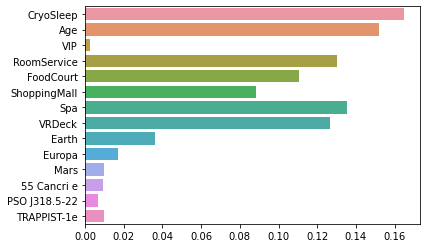

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 300, )
rf.fit(xtrain, ytrain)

# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {'max_depth': np.unique(np.random.randint(1,300, 50)),
                       'max_features': np.unique(np.random.uniform(0.5, 0.9, 50)),
                       }

clf_cv = RandomizedSearchCV(estimator = rf,
                            param_distributions = param_distributions,
                            n_iter = 10, cv = 5, 
                            scoring = 'accuracy',
                            random_state = 17, n_jobs = -1, verbose = 0)

clf_cv.fit(xtrain, ytrain)

print(clf_cv.best_score_)
print(clf_cv.best_estimator_)

# best model로 재학습
best_model = clf_cv.best_estimator_
best_model.fit(xtrain, ytrain)
y_predict = best_model.predict(xtest)

_ = sns.barplot(x = best_model.feature_importances_, y = best_model.feature_names_in_)

# 제출
df_submit['Transported'] = pd.DataFrame(y_predict)

algorithm ='original_rf'
accuracy = clf_cv.best_score_
file_name =f"{algorithm}_submit_{accuracy}_220703.csv"
df_submit.to_csv(file_name, index = False)

0.7992666711223134
LGBMClassifier(learning_rate=0.05, max_depth=10, min_child_samples=10,
               num_leaves=20, reg_alpha=0.03)


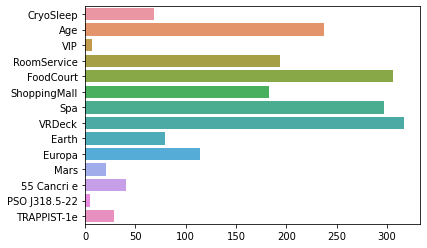

In [18]:
# lgbm
import lightgbm as lgbm

lgbm = lgbm.LGBMClassifier()
lgbm.fit(xtrain, ytrain)
param_distributions = {'num_leaves':[20,40,60,80,100], 
                       'min_child_samples':[5,10,15],
                       'max_depth':[-1,5,10,20],
                       'learning_rate':[0.05,0.1,0.2],
                       'reg_alpha':[0,0.01,0.03]}

clf_cv = RandomizedSearchCV(estimator = lgbm,
                            param_distributions = param_distributions,
                            scoring='accuracy',
                            n_iter=10, cv = 5, verbose = 0, n_jobs = -1, )

clf_cv.fit(xtrain, ytrain)

print(clf_cv.best_score_)
print(clf_cv.best_estimator_)

best_model = clf_cv.best_estimator_
best_model.fit(xtrain, ytrain)
y_predict = best_model.predict(xtest)

_ = sns.barplot(x = best_model.feature_importances_, y = feature_new)

# 제출
df_submit['Transported'] = pd.DataFrame(y_predict)
algorithm ='original_lgbm'
accuracy = clf_cv.best_score_
file_name =f"{algorithm}_submit_{accuracy}_220703.csv"
df_submit.to_csv(file_name, index = False)
# pd.read_csv('/content/2nd_lgbm_submit_0.7458910885520096_220703.csv').head(3)